In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import requests
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yfinance as yf
import time
import threading
import queue

In [46]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%m/%d/%Y %H:%M:%S')
logger = logging.getLogger()

In [47]:
ticker = 'NVDA'

scaler = MinMaxScaler(feature_range=(0, 1))

prediction_queue = queue.Queue()

In [48]:
def fetch_stock_data():
    """Fetch latest NVDA stock data and preprocess it."""
    global df_scaled  

    try:
        # Fetch last 100 days of hourly data
        stock_data = yf.download(ticker, period="100d", interval="1h")

        # Check if data is empty
        if stock_data.empty:
            logger.warning("No new stock data available. Skipping update.")
            return None  

        df = stock_data[['Close']]  

        # Scale the data
        scaled_data = scaler.fit_transform(df)
        df_scaled = pd.DataFrame(scaled_data, columns=['Close'], index=df.index)

        logger.info(f"Latest NVDA Data Updated at {df.index[-1]}")
        return df_scaled

    except Exception as e:
        logger.error(f"Error fetching stock data: {e}")
        return None  

# Fetch initial dataset
df_scaled = fetch_stock_data()

[*********************100%***********************]  1 of 1 completed
04/08/2025 14:47:39 - INFO - Latest NVDA Data Updated at 2025-04-08 19:30:00+00:00


In [49]:
def real_time_update(interval=600):
    """Update stock data every 10 minutes."""
    while True:
        df_scaled = fetch_stock_data()
        if df_scaled is not None:
            logger.info("Stock data successfully updated.")
        else:
            logger.warning("Failed to update stock data.")

        logger.info(f"Waiting {interval // 60} minutes for next update...")
        time.sleep(interval)

# real_time_update()

In [50]:
def split_data():
    """Split data into training and test sets."""
    global df_scaled

    if df_scaled is None:
        logger.error("No data to split.")
        return None, None
    
    train_size = int(len(df_scaled) * 0.80)
    
    train_data = df_scaled.iloc[:train_size]
    test_data = df_scaled.iloc[train_size:]

    logger.info(f"Data split into train and test sets. Train size: {len(train_data)}, Test size: {len(test_data)}")

    return train_data, test_data

train_data, test_data = split_data()

04/08/2025 14:47:39 - INFO - Data split into train and test sets. Train size: 553, Test size: 139


In [51]:
def create_data_sequence(data, seq_length=60):
    """Create sequences of data."""
    X, y = [], []
    for i in range(len(data) - seq_length):
        #last day sequence length
        X.append(data.iloc[i:i + seq_length].values)
        #next day close price
        y.append(data.iloc[i + seq_length].values)
    return np.array(X), np.array(y)


#Generate sequences of data
if train_data is not None and test_data is not None:
    seq_length = 60
    X_train, y_train = create_data_sequence(train_data, seq_length=60)
    X_test, y_test = create_data_sequence(test_data, seq_length=60)

    #Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    logger.info(f"x_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
else:
    logger.warning("No data to create sequences.")



04/08/2025 14:47:39 - INFO - x_train shape: torch.Size([493, 60, 1]), y_train shape: torch.Size([493, 1])


In [52]:
def plot_data():
    """Plot stock data."""
    if df_scaled is None or df_scaled.empty:
        logger.warning("No data to plot.")
        return None

    plt.figure(figsize=(12, 6))
    plt.title(f"{ticker} Stock Price")
    plt.plot(df_scaled, label='Close Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [53]:
class StockLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=128, num_layers=3, output_size=1):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out
    
model = StockLSTM()

In [54]:
# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss (for regression)
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Adam optimizer


In [55]:
num_epochs = 300
patience = 15
best_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if epoch % 5 == 0:
        logger.info(f'Epoch {epoch} - Loss: {loss.item()}')
    
    if loss.item() < best_loss:
        best_loss = loss.item()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            logger.info(f"Early stopping at epoch {epoch}. Best loss: {best_loss:.4f}")
            break


04/08/2025 14:47:39 - INFO - Epoch 0 - Loss: 0.4703187942504883
04/08/2025 14:47:42 - INFO - Epoch 5 - Loss: 0.31429392099380493
04/08/2025 14:47:44 - INFO - Epoch 10 - Loss: 0.1327597051858902
04/08/2025 14:47:47 - INFO - Epoch 15 - Loss: 0.07460825145244598
04/08/2025 14:47:49 - INFO - Epoch 20 - Loss: 0.024859808385372162
04/08/2025 14:47:52 - INFO - Epoch 25 - Loss: 0.039780255407094955
04/08/2025 14:47:54 - INFO - Epoch 30 - Loss: 0.028635507449507713
04/08/2025 14:47:57 - INFO - Epoch 35 - Loss: 0.026346249505877495
04/08/2025 14:47:59 - INFO - Epoch 40 - Loss: 0.025853978469967842
04/08/2025 14:48:02 - INFO - Epoch 45 - Loss: 0.02388167753815651
04/08/2025 14:48:04 - INFO - Epoch 50 - Loss: 0.02382977120578289
04/08/2025 14:48:07 - INFO - Epoch 55 - Loss: 0.022060643881559372
04/08/2025 14:48:10 - INFO - Epoch 60 - Loss: 0.02157416380941868
04/08/2025 14:48:12 - INFO - Epoch 65 - Loss: 0.0200567115098238
04/08/2025 14:48:15 - INFO - Epoch 70 - Loss: 0.018521346151828766
04/08/20

In [56]:
torch.save(model.state_dict(), "stock_lstm.pth")
logger.info("Model training complete. Saved as stock_lstm.pth")


04/08/2025 14:50:17 - INFO - Model training complete. Saved as stock_lstm.pth


In [57]:
# Load trained model
model.load_state_dict(torch.load("stock_lstm.pth"))
model.eval()  # Set to evaluation mode
logger.info("Model loaded successfully for predictions.")


04/08/2025 14:50:17 - INFO - Model loaded successfully for predictions.


In [58]:
with torch.no_grad():  # Disable gradient calculations for predictions
    y_pred = model(X_test)
# Convert predictions back to original scale
y_pred = y_pred.numpy()
y_pred = scaler.inverse_transform(y_pred)  # Reverse MinMax Scaling
y_test_actual = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

# Print a few predictions
print(f"Sample Predictions: {y_pred[:5].flatten()}")
print(f"Actual Prices: {y_test_actual[:5].flatten()}")


Sample Predictions: [119.12818  119.74593  120.215034 120.45599  120.50368 ]
Actual Prices: [121.795006 121.23     119.98     120.26159  120.6602  ]


In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

logger.info(f"RMSE: {rmse:.4f}")
logger.info(f"MAE: {mae:.4f}")


04/08/2025 14:50:17 - INFO - RMSE: 3.9828
04/08/2025 14:50:17 - INFO - MAE: 2.9840


RMSE: 3.9828
MAE: 2.9840


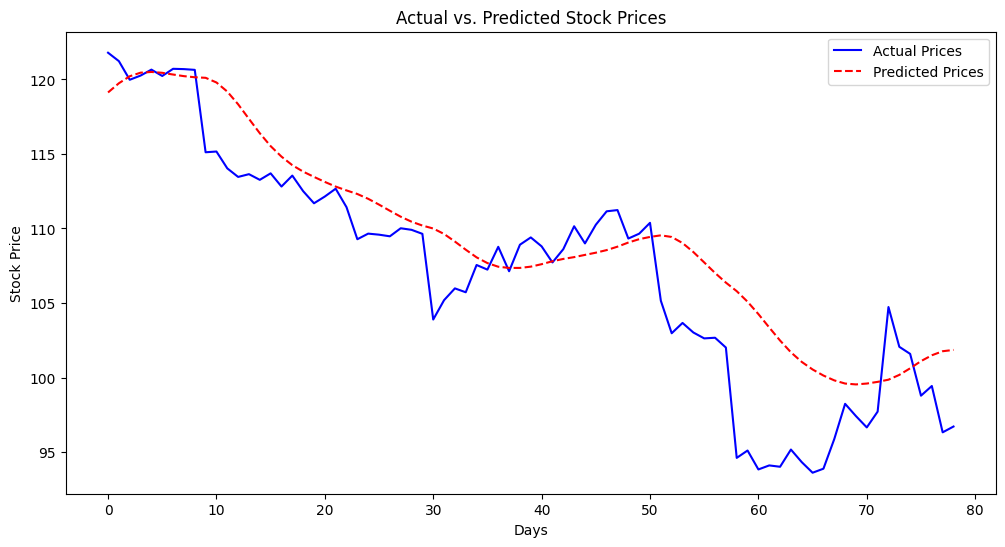

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Prices", color="blue")
plt.plot(y_pred, label="Predicted Prices", color="red", linestyle="dashed")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.title("Actual vs. Predicted Stock Prices")
plt.legend()
plt.show()


In [61]:
def get_latest_stock_price():
    """Fetch latest NVDA stock price and preprocess for real-time prediction."""
    latest_data = yf.download("NVDA", period="15d", interval="1h")  # Increase to 15 days
    df_latest = latest_data[['Close']]  # Keep only 'Close' price

    # Check if we have enough data
    if len(df_latest) < 60:
        print(f"Not enough data available. Found only {len(df_latest)} data points.")
        logger.warning(f"Not enough data available. Found only {len(df_latest)} data points.")
        return None  # Return None instead of crashing

    # Scale the last 60 values using MinMaxScaler
    scaled_latest = scaler.transform(df_latest.values[-60:].reshape(-1, 1))

    return np.array(scaled_latest).reshape(1, 60, 1)  # Reshape for LSTM input

# Fetch the latest stock price
x_real_time = get_latest_stock_price()

# Check if valid data is available
if x_real_time is None:
    print("Skipping prediction due to insufficient data.")
    logger.error("Skipping prediction due to insufficient data.")
else:
    print("Real-time data successfully processed.")

[*********************100%***********************]  1 of 1 completed

Real-time data successfully processed.


In [62]:
# Predict next stock price if we have enough data
if x_real_time is not None:
    with torch.no_grad():
        predicted_price = model(torch.tensor(x_real_time, dtype=torch.float32))

    # Convert back to original scale
    predicted_price = scaler.inverse_transform(predicted_price.numpy().reshape(-1, 1))

    # Print real-time prediction
    print(f"Predicted Next NVDA Stock Price: ${predicted_price[0][0]:.2f}")
    logger.info(f"Predicted Next NVDA Stock Price: ${predicted_price[0][0]:.2f}")
else:
    print("Skipping real-time prediction due to insufficient data.")
    logger.error("Skipping real-time prediction due to insufficient data.")


04/08/2025 14:50:17 - INFO - Predicted Next NVDA Stock Price: $101.78


Predicted Next NVDA Stock Price: $101.78


In [63]:
def real_time_prediction_loop(interval=600):  # 600 seconds = 10 minutes
    """Continuously predicts NVDA stock price in real-time at regular intervals."""
    while True:
        x_real_time = get_latest_stock_price()
        
        if x_real_time is not None:
            with torch.no_grad():
                predicted_price = model(torch.tensor(x_real_time, dtype=torch.float32))

            # Convert back to original scale
            predicted_price = scaler.inverse_transform(predicted_price.numpy().reshape(-1, 1))
            new_price = predicted_price[0][0]

            # Print and log the prediction
            logger.info(f"Real-Time NVDA Prediction: ${predicted_price[0][0]:.2f}")
            prediction_queue.put(new_price)
        else:
            logger.error("Skipping prediction due to insufficient data.")

        time.sleep(interval)  # Wait for the next prediction cycle




In [64]:
import matplotlib.pyplot as plt

def plot_predictions(y_test_actual, y_pred):
    """Plots actual vs predicted stock prices."""
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_actual, label="Actual Prices", color="blue")
    plt.plot(y_pred, label="Predicted Prices", color="red", linestyle="dashed")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.title("Actual vs. Predicted NVDA Stock Prices")
    plt.legend()
    plt.show()


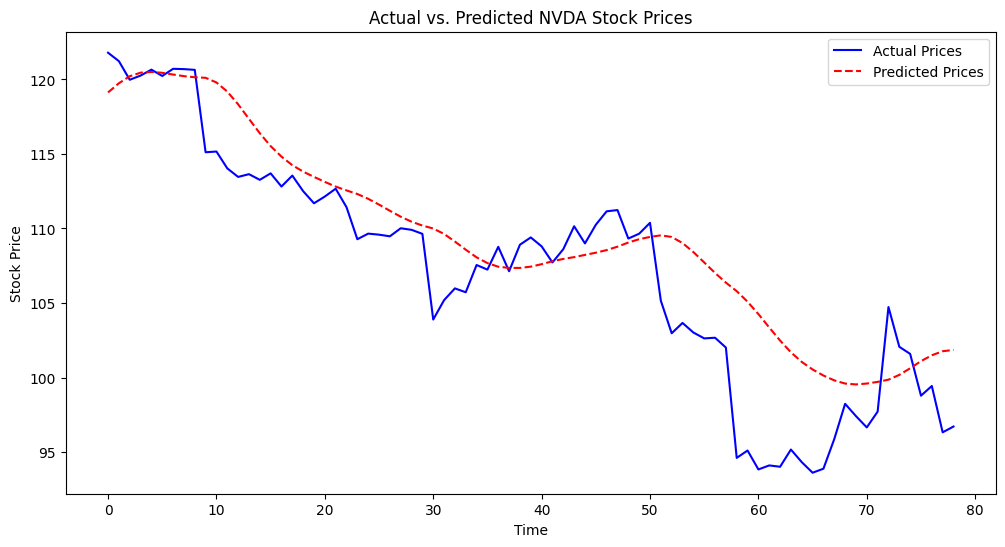

In [65]:
plot_predictions(y_test_actual, y_pred)


In [66]:
import time
import matplotlib.pyplot as plt

# Store historical predictions
def update_real_time_plot():

    """Continuously updates the real-time stock price prediction graph."""
    plt.ion()  # Turn on interactive mode for live updating
    fig, ax = plt.subplots(figsize=(12, 6))

    real_time_prices = []
    timestamps = []

    while True:
        try:
            new_price = prediction_queue.get(timeout=610)  # **Get price safely from queue**
            real_time_prices.append(new_price)
            timestamps.append(len(real_time_prices))  # Ensure timestamps increment correctly

            # **Update the plot without clearing previous points**
            ax.clear()
            ax.plot(timestamps, real_time_prices, 'ro-', label="Real-Time Predicted Price", linestyle="dashed")

            ax.set_xlabel("Time (Every 10 min)")
            ax.set_ylabel("Stock Price")
            ax.set_title("Live NVDA Stock Price Prediction")
            ax.legend()

            plt.draw()
            plt.pause(600)  # Pause before updating

        except queue.Empty:
            logger.warning("No new predictions received, skipping update.")

# **Start the real-time prediction thread**
prediction_thread = threading.Thread(target=real_time_prediction_loop, daemon=True)  # Background thread for fetching predictions
prediction_thread.start()

# **Run the real-time visualization in the main thread**
# update_real_time_plot()



[*********************100%***********************]  1 of 1 completed
04/08/2025 14:50:17 - INFO - Real-Time NVDA Prediction: $101.78
